In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [38]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        social_media =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


In [39]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Day_Of_Week,Genre, n_tokens_title, num_keywords, title_subjectivity, abs_title_subjectivity, title_sentiment_polarity,abs_title_sentiment_polarity, shares)



In [40]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.75, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)


Day_Of_Week,Genre,n_tokens_title,num_keywords,title_subjectivity,abs_title_subjectivity,title_sentiment_polarity,abs_title_sentiment_polarity,shares
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
monday,entertainment,12,5,0.5000000,0.00000000,-0.1875000,0.1875000,593
monday,business,9,4,0.0000000,0.50000000,0.0000000,0.0000000,711
monday,business,9,6,0.0000000,0.50000000,0.0000000,0.0000000,1500
monday,entertainment,9,7,0.0000000,0.50000000,0.0000000,0.0000000,1200
monday,technology,13,7,0.4545455,0.04545455,0.1363636,0.1363636,505
monday,technology,10,9,0.6428571,0.14285714,0.2142857,0.2142857,855


`summarise()` ungrouping output (override with `.groups` argument)



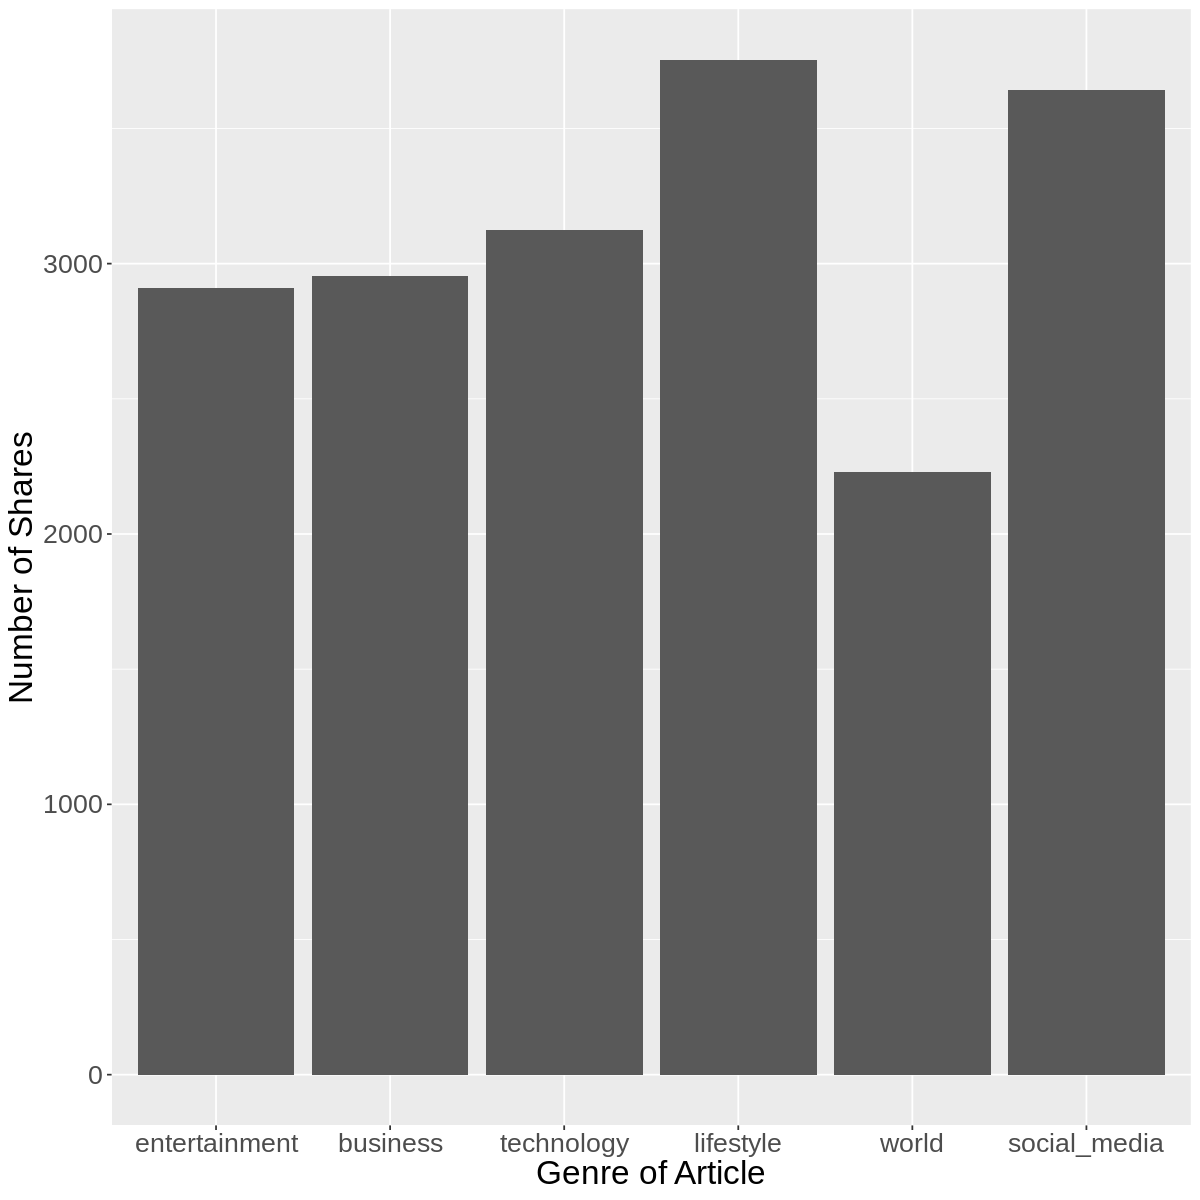

In [41]:
options(repr.plot.width = 10, repr.plot.height = 10)

genre_data <- publishing_train %>%
    group_by(Genre) %>%
    summarise(n=n(), shares = mean(shares))

share_genre_plot <- genre_data %>%
    ggplot(aes(x = Genre, y = shares)) + 
    geom_bar(stat = 'identity') +
    xlab("Genre of Article") +
    ylab("Number of Shares") +
    theme(text = element_text(size = 20))

share_genre_plot


    ggplot(aes(value, fill = Genre)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ Day_Of_Week, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))

`summarise()` ungrouping output (override with `.groups` argument)



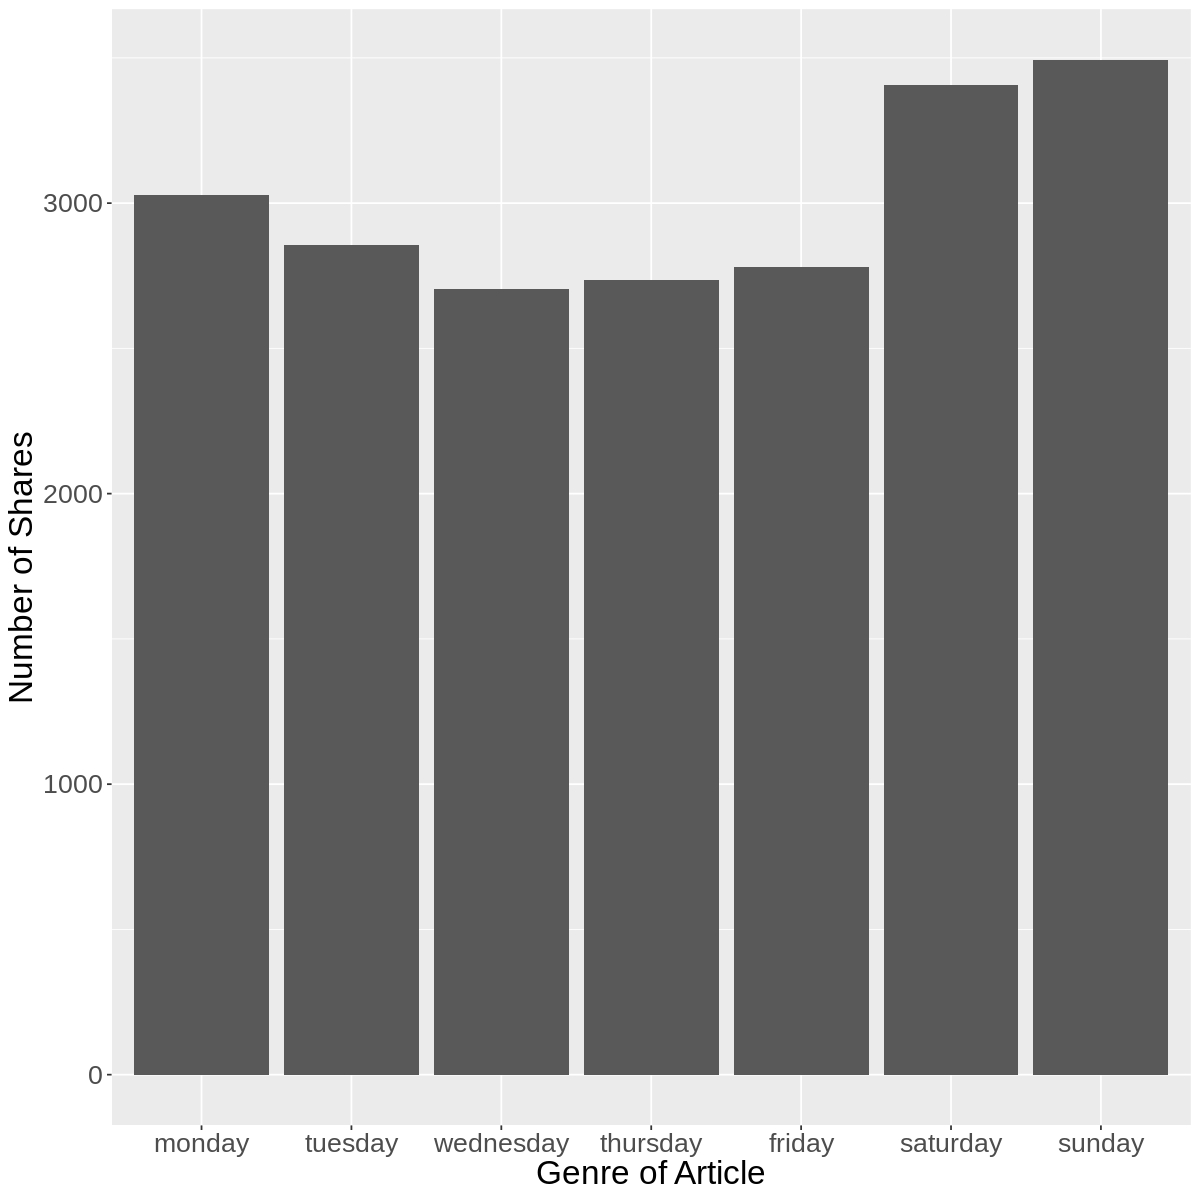

In [42]:
day_data <- publishing_train %>%
    group_by(Day_Of_Week) %>%
    summarise(n=n(), shares = mean(shares))


options(repr.plot.width = 10, repr.plot.height = 10)
share_day_plot <- day_data %>%
    ggplot(aes(x = Day_Of_Week, y = shares)) + 
    geom_bar(stat = 'identity') +
    xlab("Genre of Article") +
    ylab("Number of Shares") +
    theme(text = element_text(size = 20))

share_day_plot

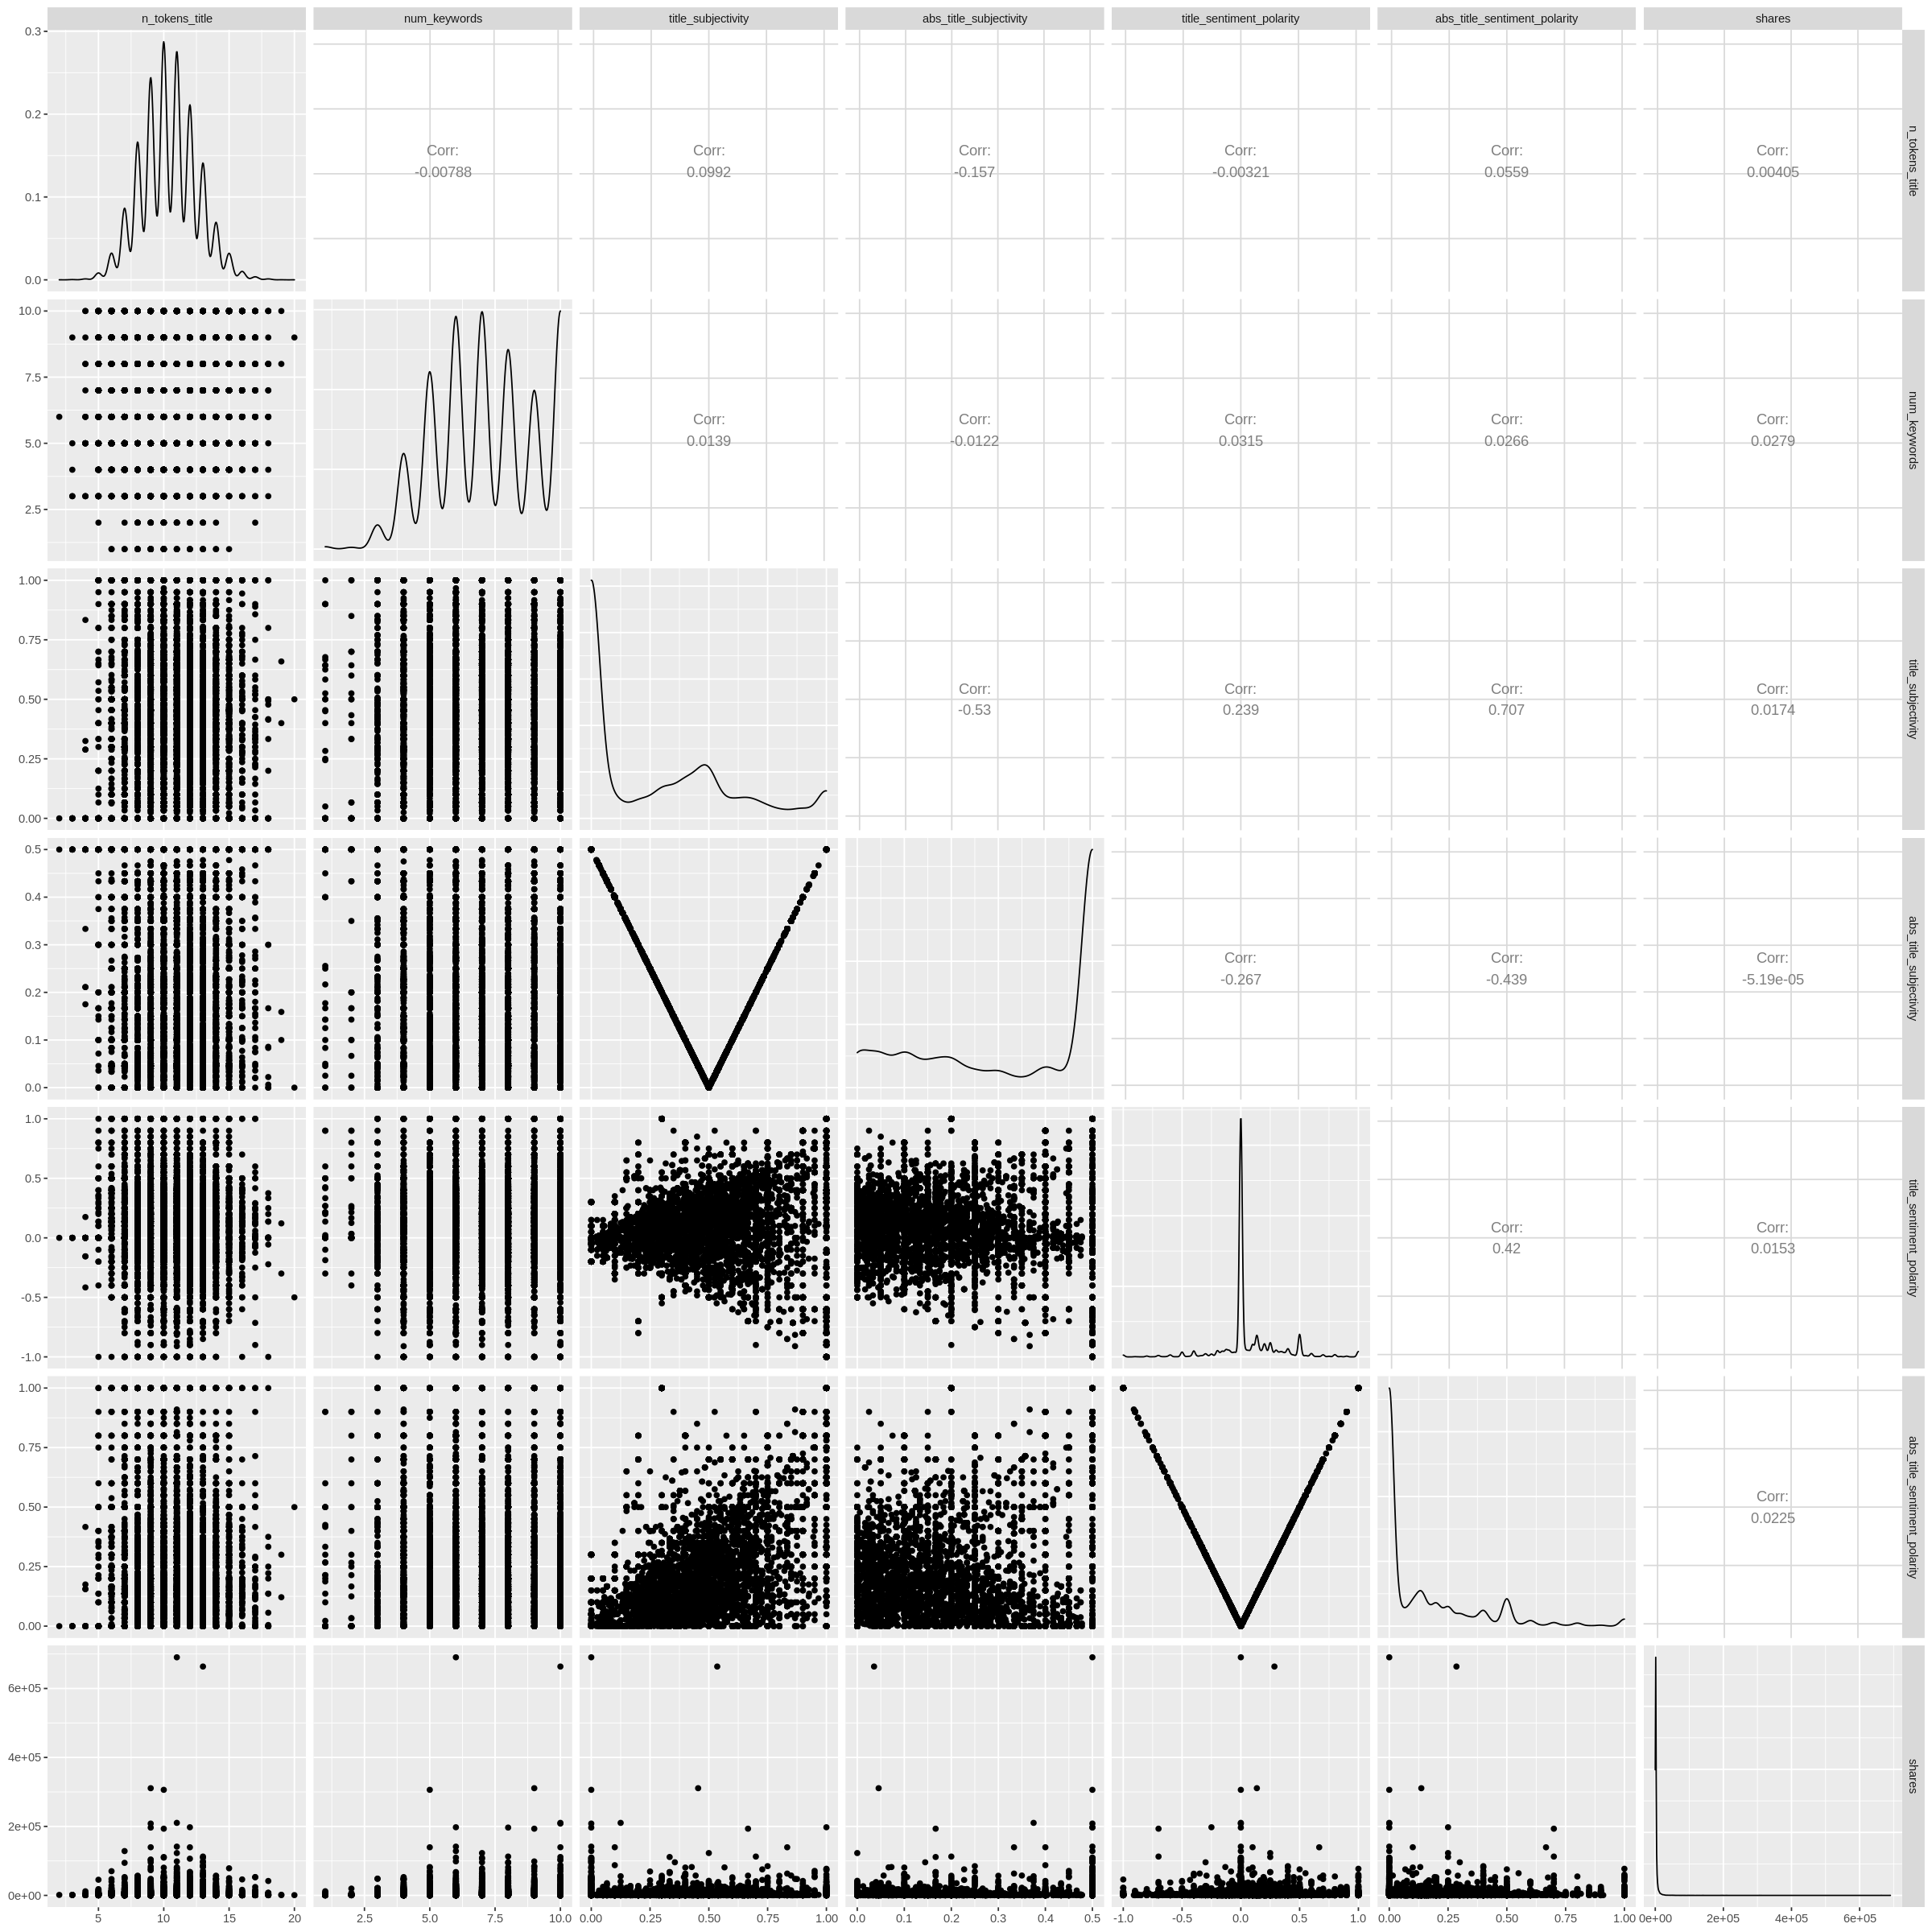

In [45]:
options(repr.plot.width = 20, repr.plot.height = 20)

pairs <- select(publishing_train, -Genre, -Day_Of_Week) %>%
    ggpairs()
pairs

In [46]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 



share_recipe <- recipe(shares ~ n_tokens_title+ num_keywords+abs_title_sentiment_polarity+Genre+Day_Of_Week, data = publishing_train) %>%
       step_scale(-shares, -Genre, -Day_Of_Week) %>%
       step_center(-shares, -Genre, -Day_Of_Week)


In [48]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)

share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 25:400) %>%
    filter(neighbors %% 25 == 0 )

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

share_results


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,rmse,standard,9.002263e+03,5,1.147497e+03,Model01
25,rsq,standard,3.935144e-04,5,1.230247e-04,Model01
50,rmse,standard,8.879356e+03,5,1.177929e+03,Model02
50,rsq,standard,1.548013e-03,5,8.258878e-04,Model02
75,rmse,standard,8.845186e+03,5,1.182324e+03,Model03
75,rsq,standard,2.015644e-03,5,9.510239e-04,Model03
100,rmse,standard,8.835678e+03,5,1.182719e+03,Model04
100,rsq,standard,1.888758e-03,5,8.112689e-04,Model04
125,rmse,standard,8.824301e+03,5,1.184605e+03,Model05


In [49]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
375,rmse,standard,8797.236,5,1190.789,Model15


In [50]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)


share_summary <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test) %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.044232e+04
rsq,standard,3.288346e-03
mae,standard,2.591924e+03


[1] 10458.32

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



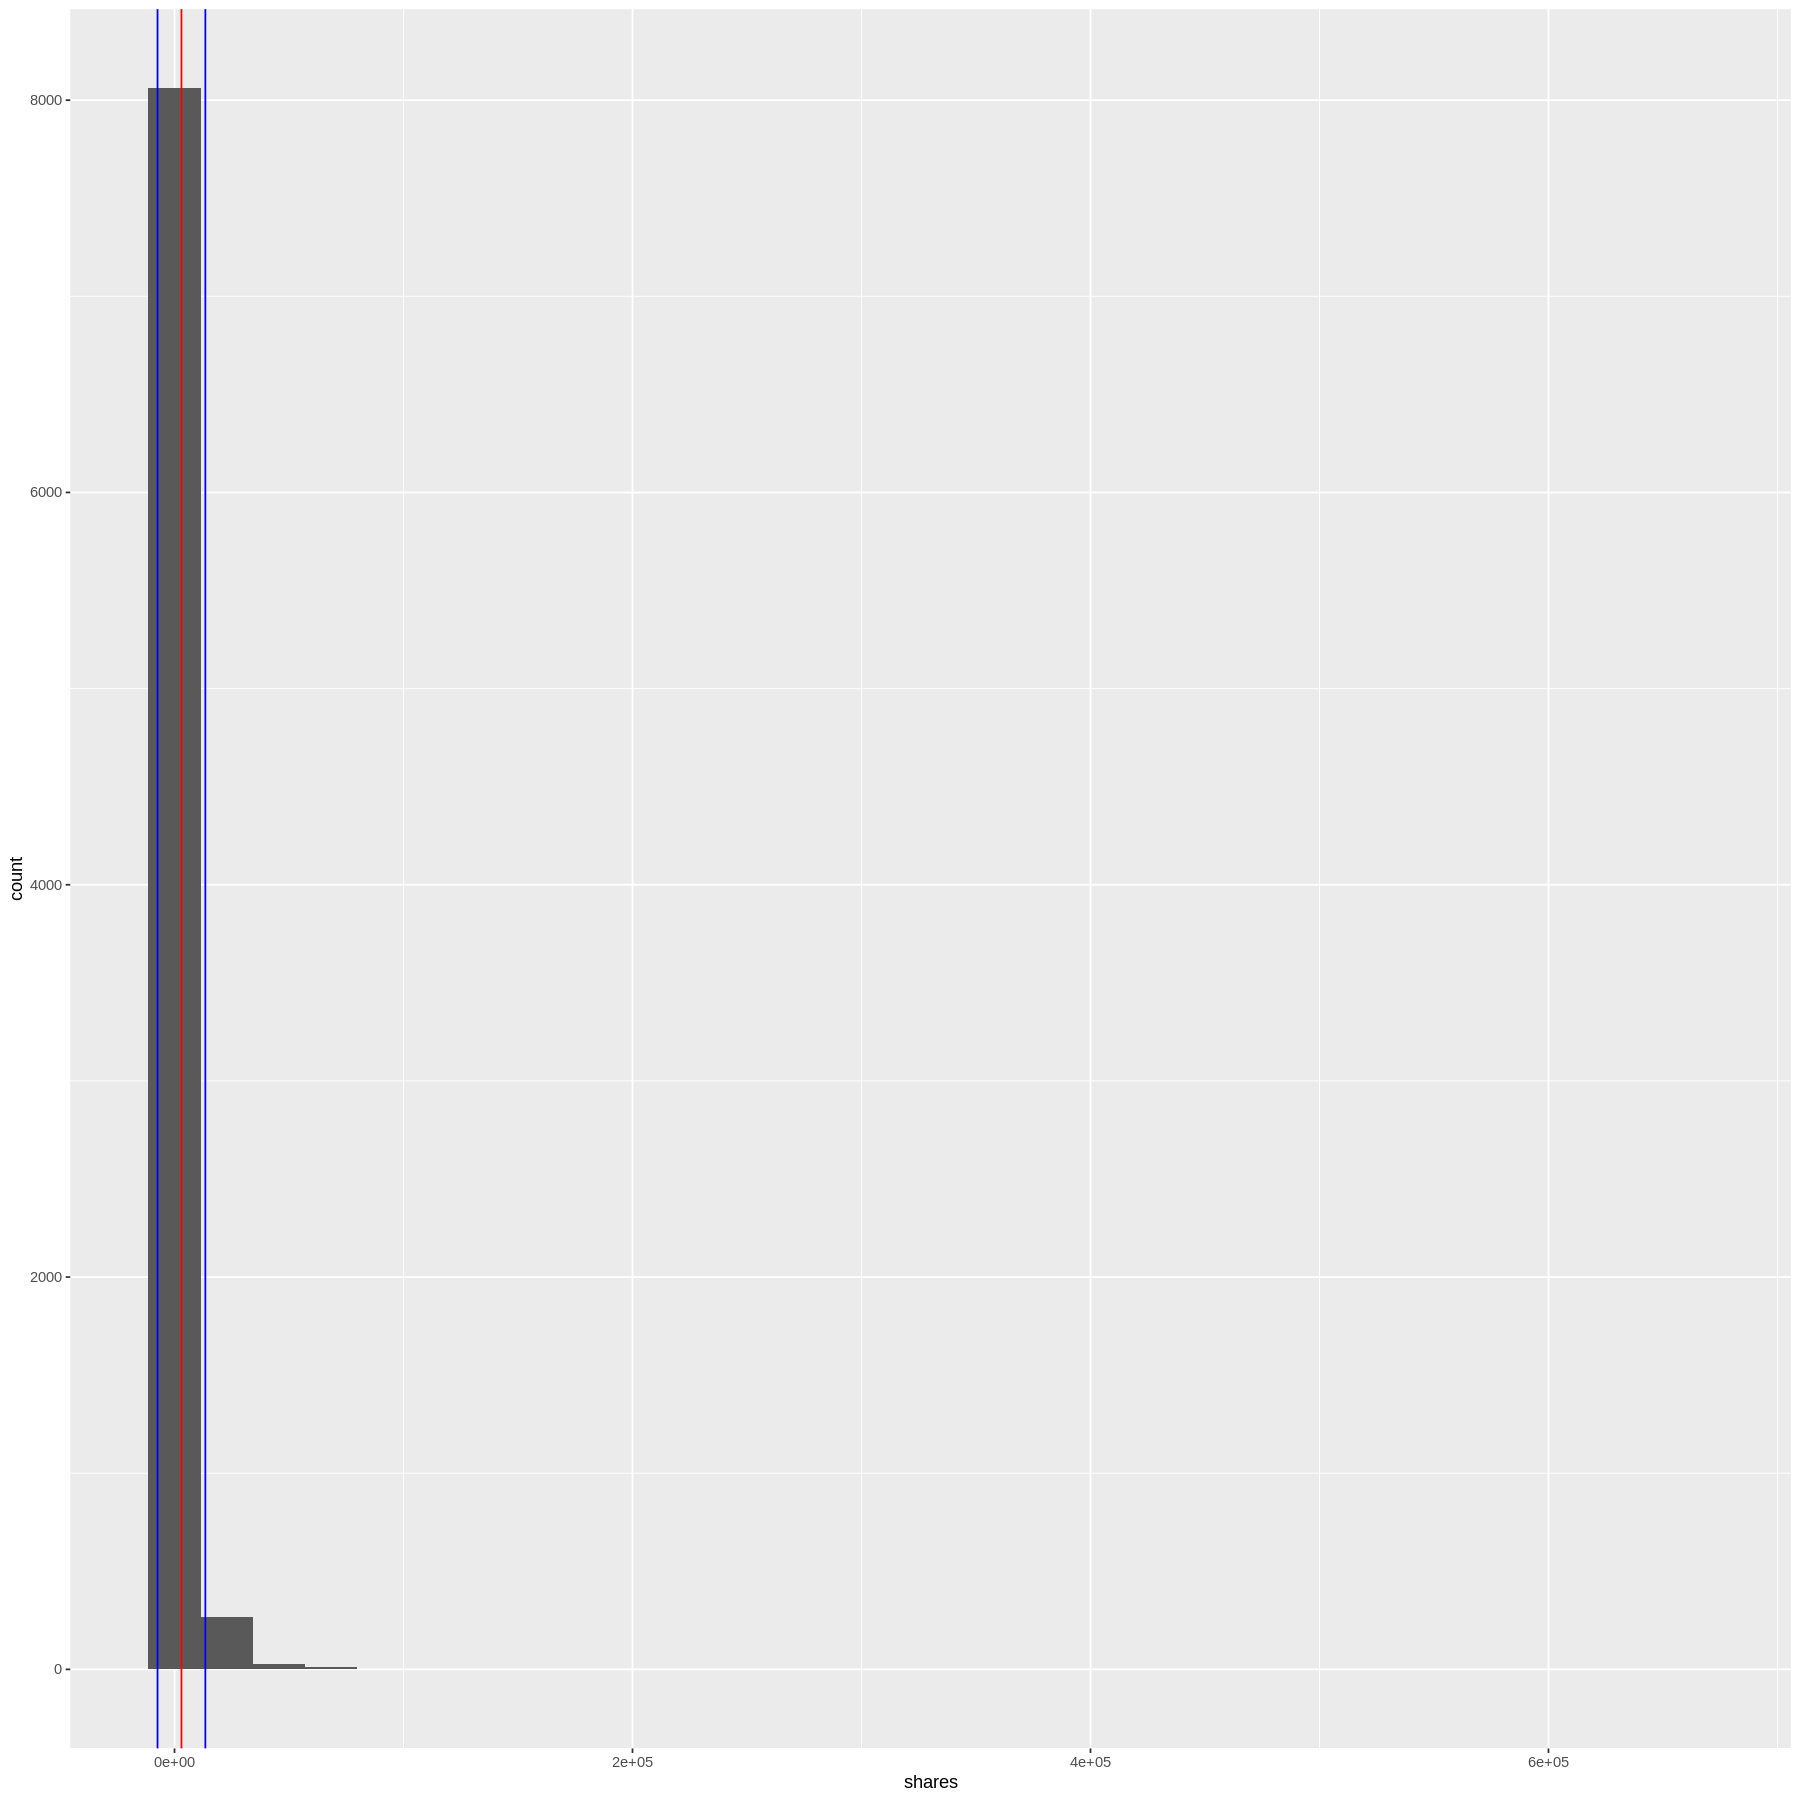

In [51]:
share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

options(repr.plot.width = 15, repr.plot.height = 15)


lm_rmspe <- share_summary %>%
          filter(.metric == "rmse") %>%
          select(.estimate) %>%
          pull()

std_dev <- pull(summarize(publishing_test, sd(shares)))
mean <- pull(summarize(publishing_test, mean(shares)))
std_dev



ggplot(publishing_test, aes(x=shares)) +
    geom_histogram()+
    geom_vline(aes(xintercept=mean+lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean-lm_rmspe),color="blue")+
    geom_vline(aes(xintercept=mean),color="red")

ggplot(publishing_test)

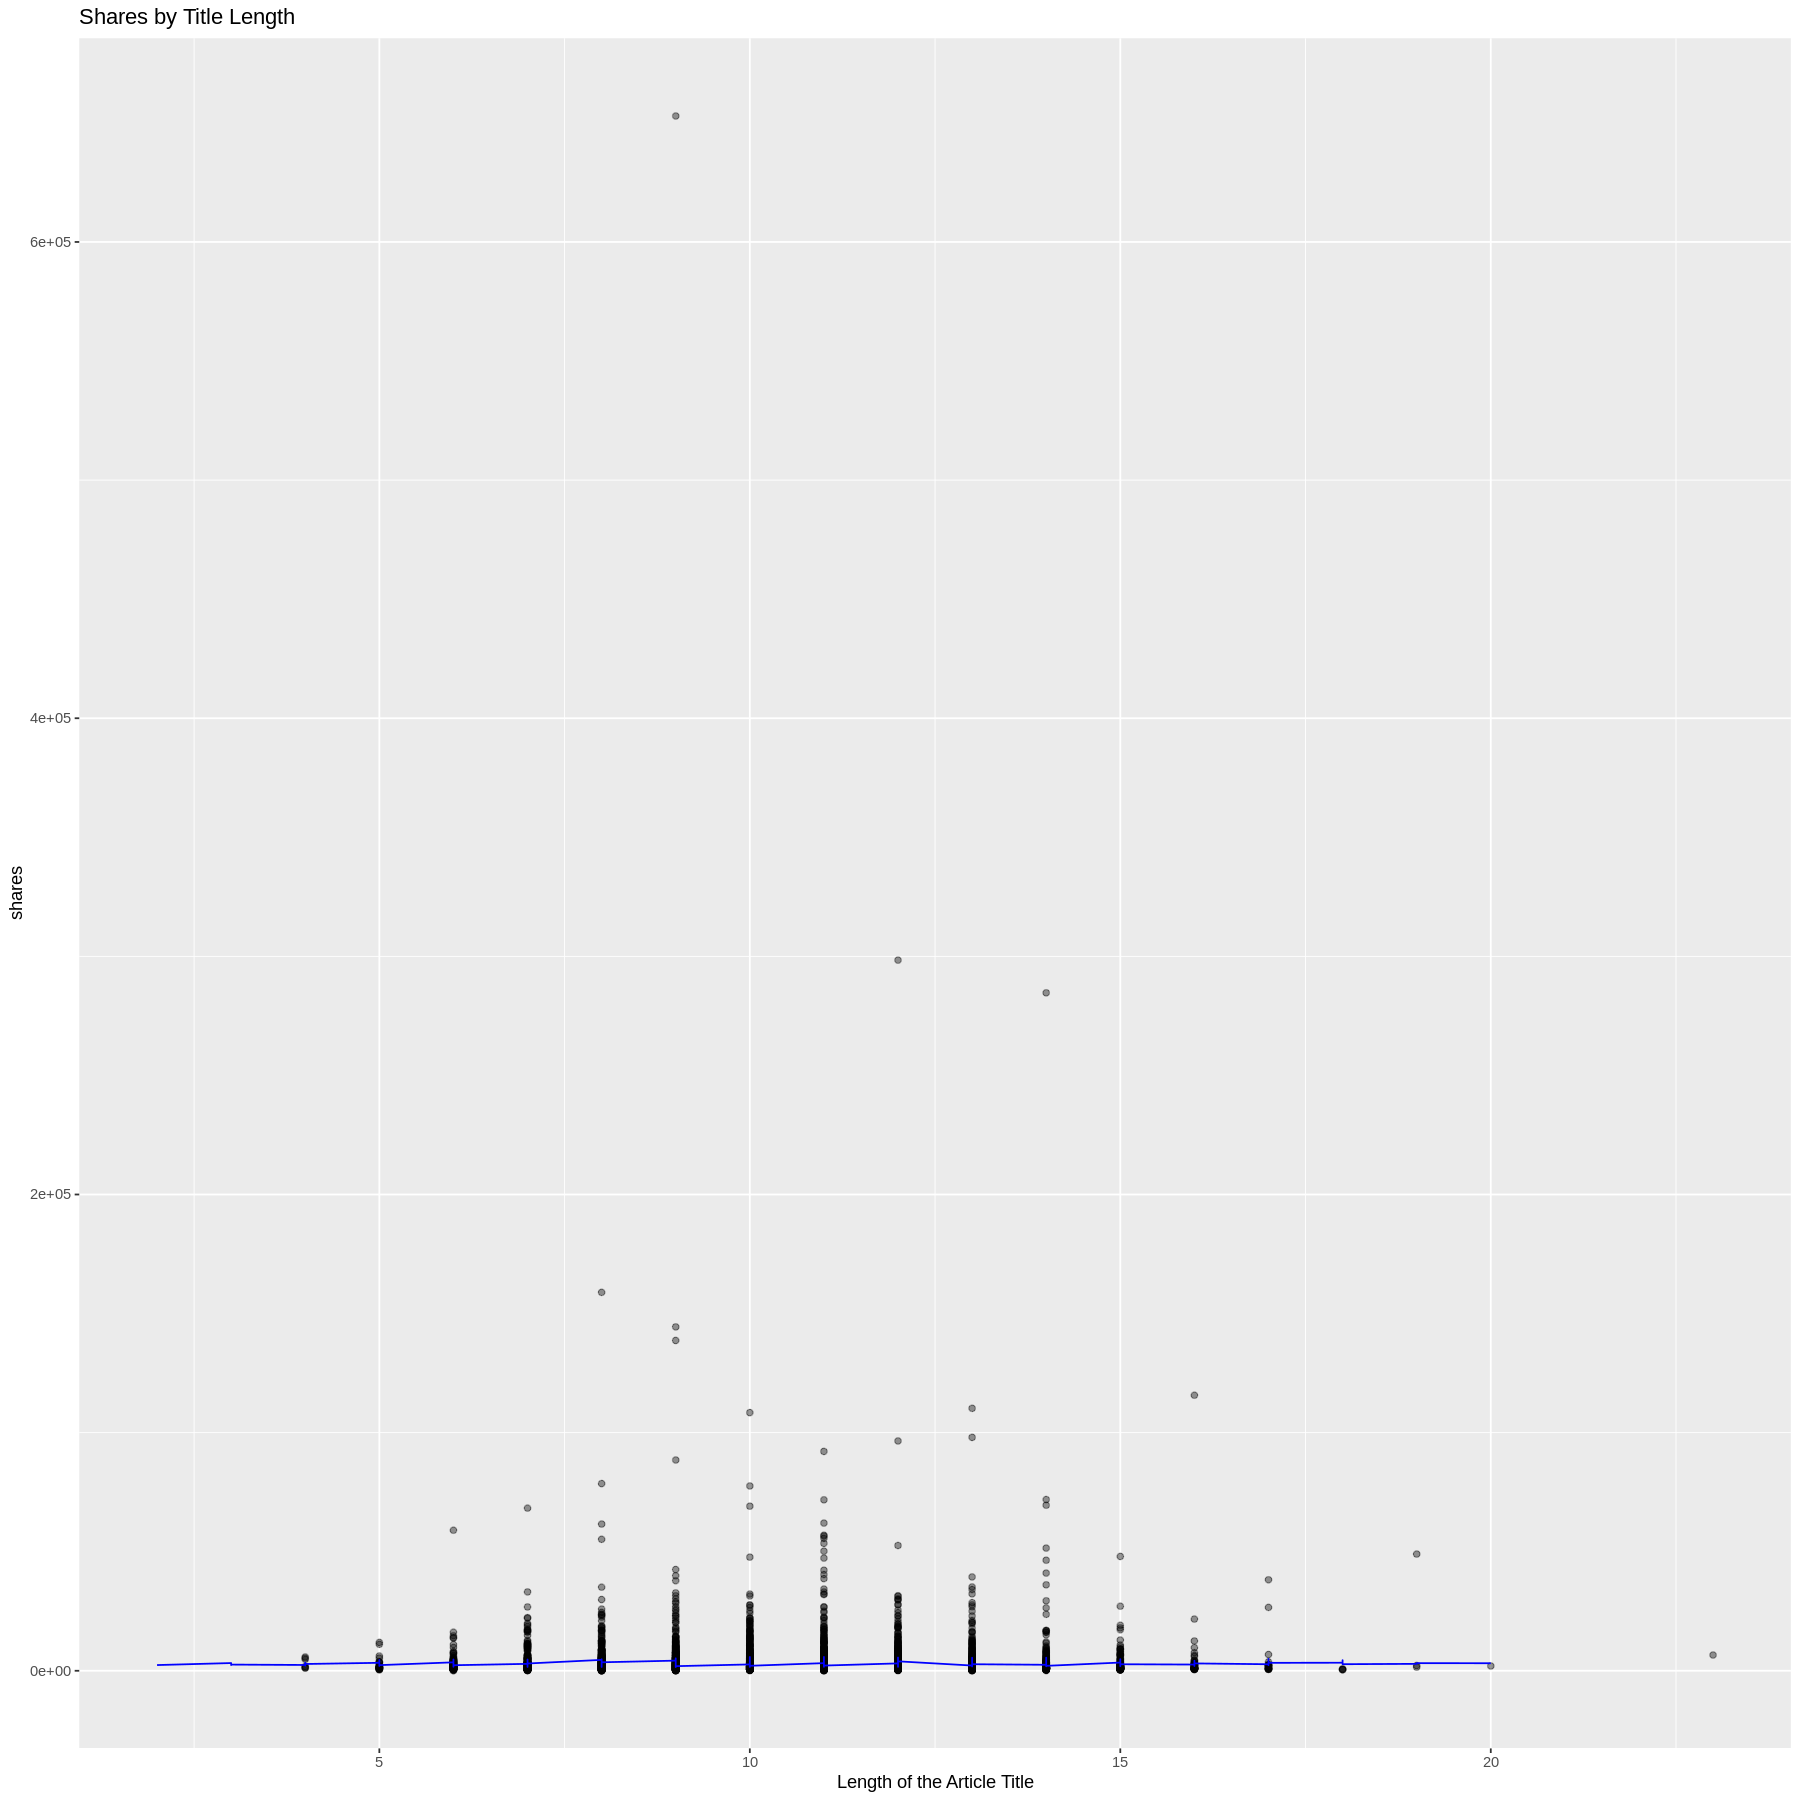

In [53]:
share_preds <- share_best_fit %>%
    predict(publishing_train) %>%
    bind_cols(publishing_train)

options(repr.plot.width = 15, repr.plot.height = 15)


title_length_plot <- ggplot(publishing_test, aes(x = n_tokens_title, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Length of the Article Title")+
  geom_line(data = share_preds, aes(x = n_tokens_title, y = .pred), color = "blue")+
  ggtitle("Shares by Title Length")
title_length_plot

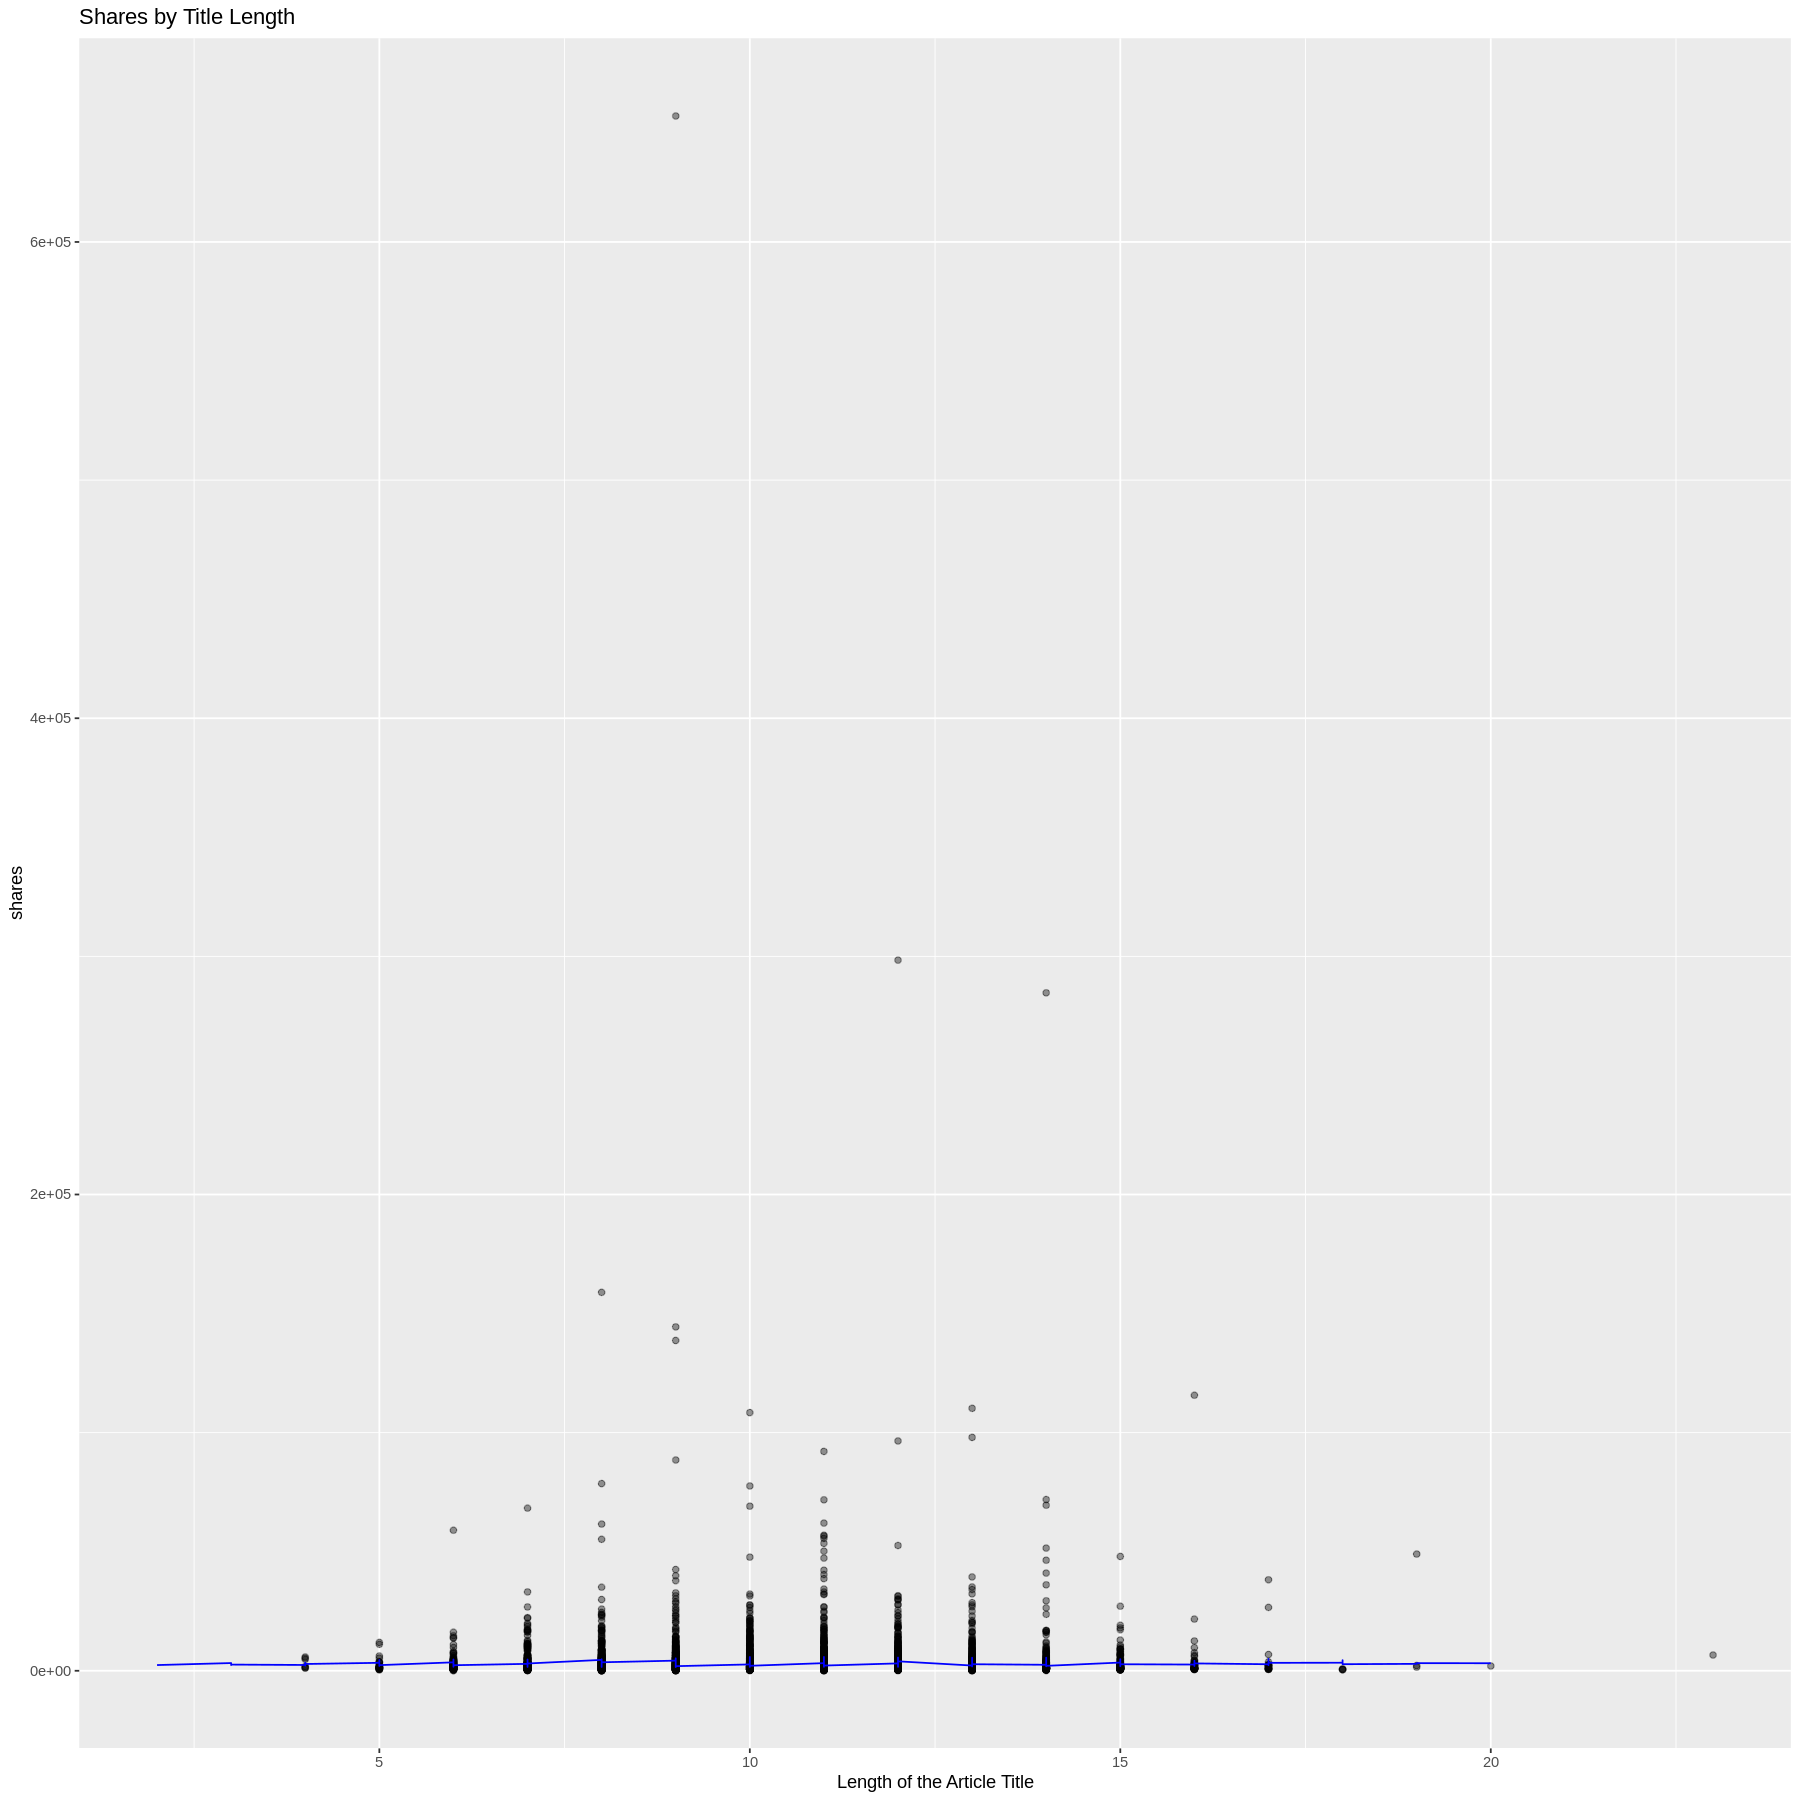

In [54]:
metadata_plot <- ggplot(publishing_test, aes(x = n_tokens_title, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Length of the Article Title")+
  geom_line(data = share_preds, aes(x = n_tokens_title, y = .pred), color = "blue")+
  ggtitle("Shares by Title Length")
metadata_plot

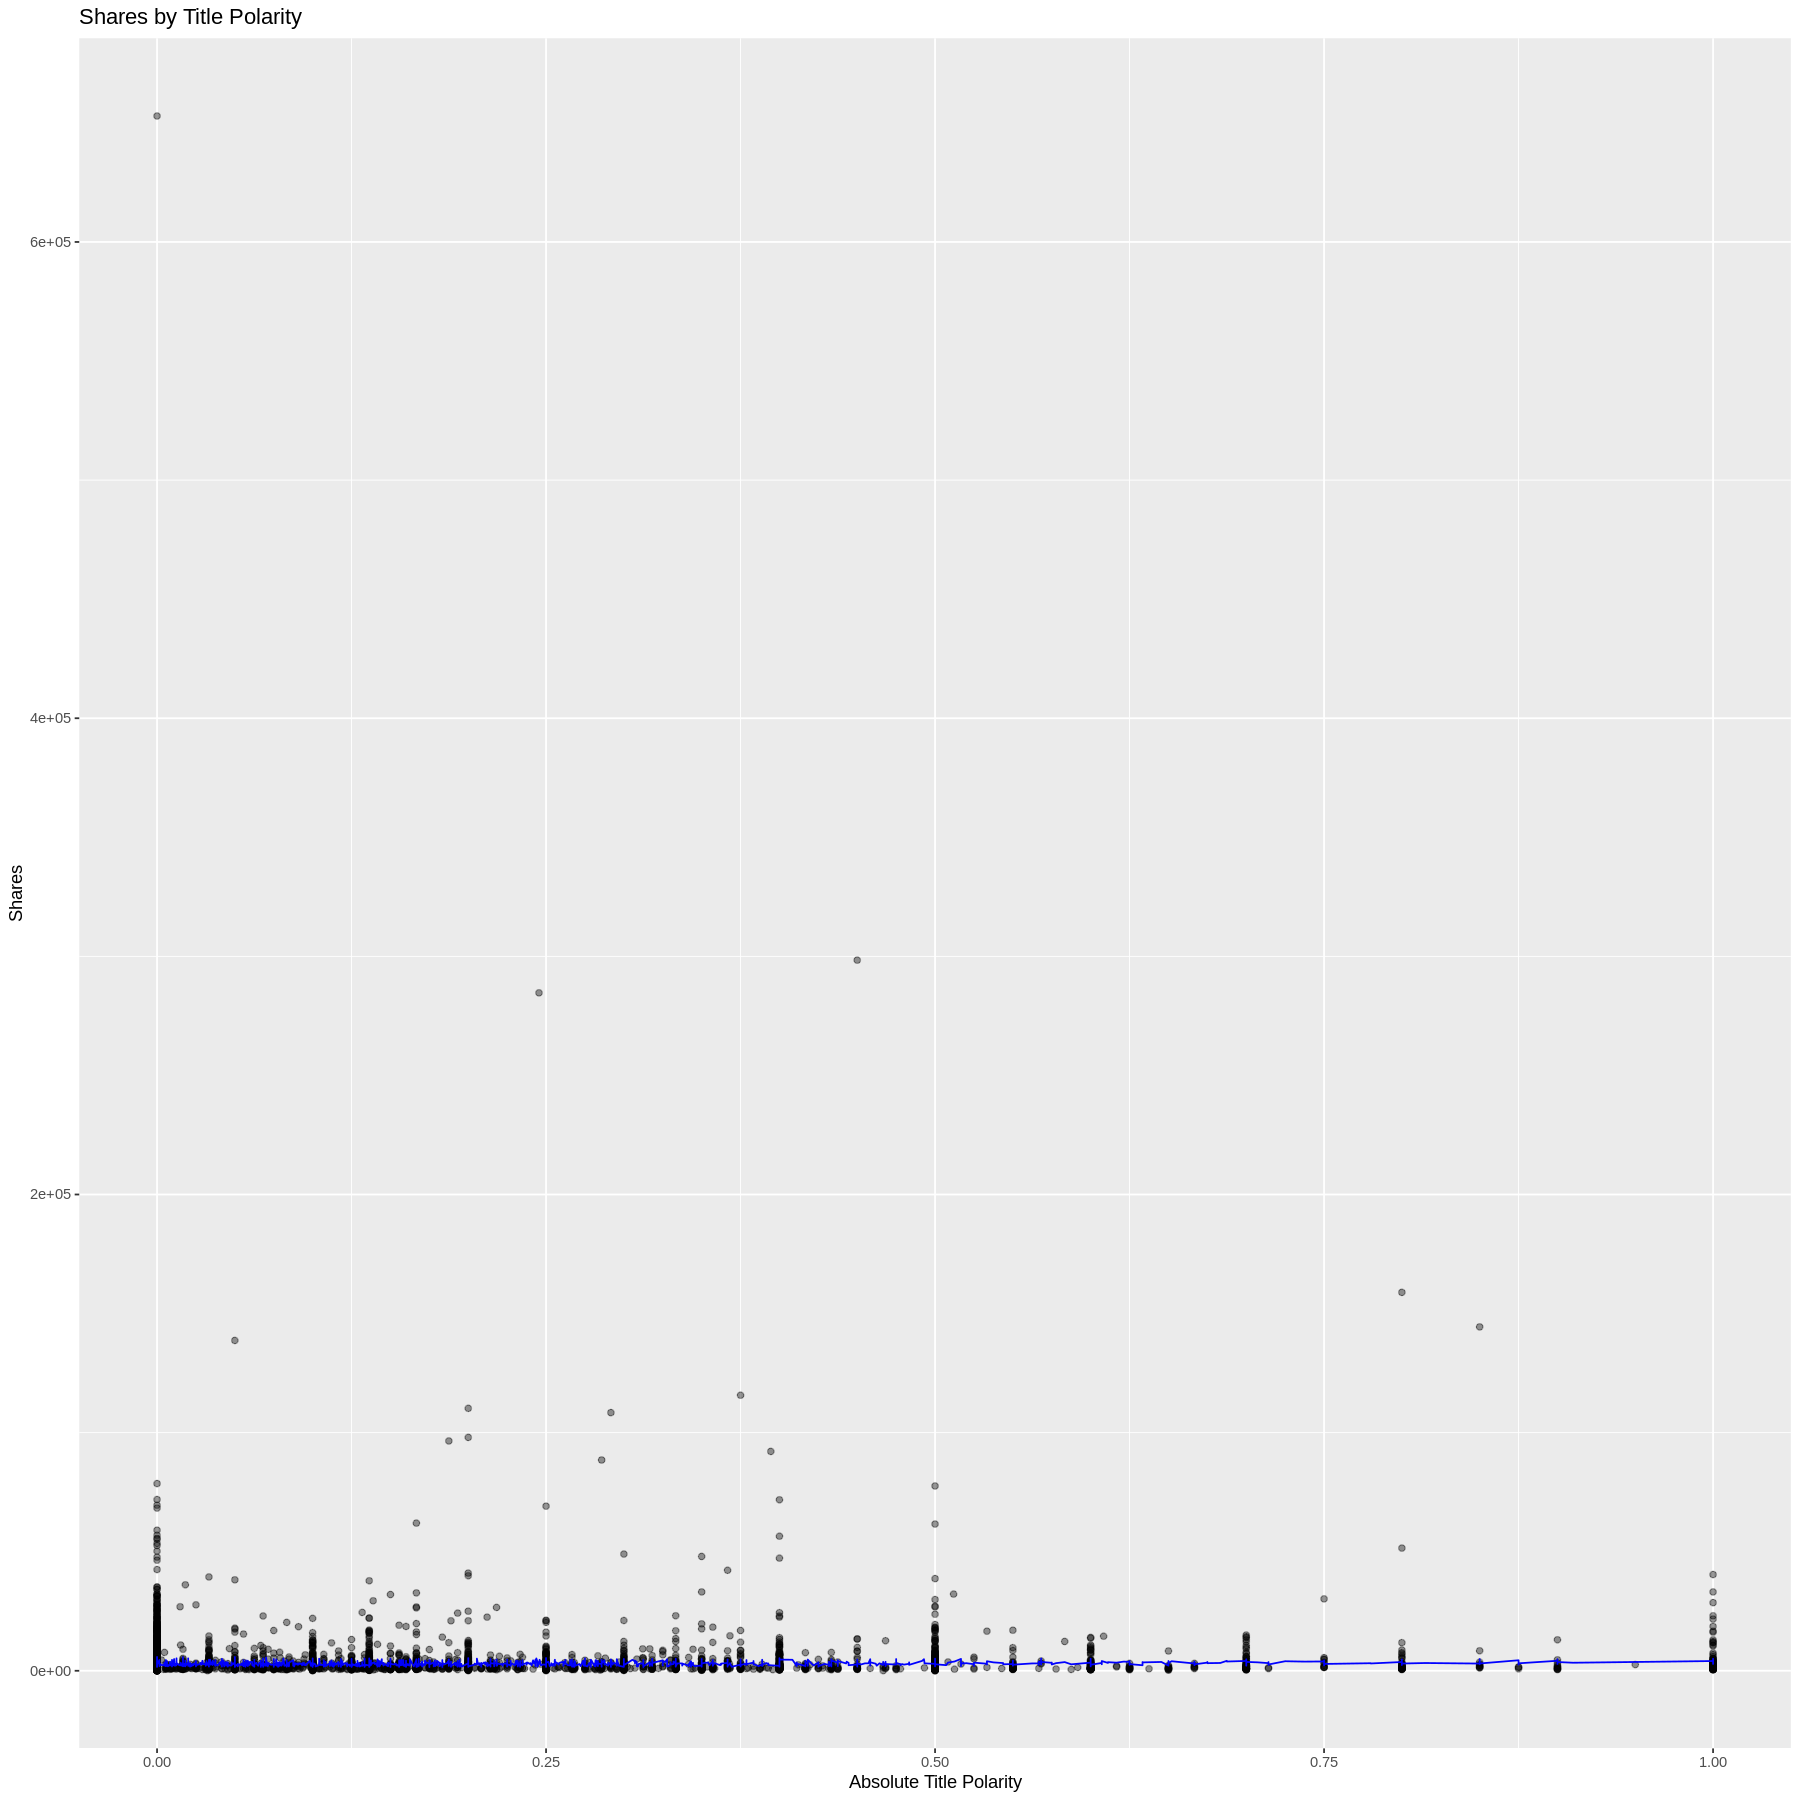

In [55]:
title_polarity_plot <- ggplot(publishing_test, aes(x = abs_title_sentiment_polarity, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Absolute Title Polarity", y="Shares")+
  geom_line(data = share_preds, aes(x = abs_title_sentiment_polarity, y = .pred), color = "blue")+
  ggtitle("Shares by Title Polarity")
title_polarity_plot